# Golden Cross / Death Cross SPY (GLD)

    1. sma50>sma200, buy SPY
    2. sma50<sma200, sell your long SPY position
    3. when out of your SPY position, hold GLD

In [1]:
# use future imports for python 3.x forward compatibility
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
from __future__ import absolute_import

# other imports
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

# project imports
import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
#symbol = '^GSPC'
symbol = 'SPY'
other_symbol = 'GLD'
#other_symbol = 'TLT'
#other_symbol = 'SHY'
#other_symbol = 'SH'

capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

Include dividends? (If yes, set to True)

In [4]:
use_adj = True

Use cache?

In [5]:
use_cache = False

Fetch symbol data from internet; use cache if available.

In [6]:
ts = pf.fetch_timeseries(symbol, use_cache=use_cache)
ts.head()

,high,low,open,close,volume,adj_close
date,,,,,,
1993-01-29,43.97,43.75,43.97,43.94,1003200.00,26.45
1993-02-01,44.25,43.97,43.97,44.25,480500.00,26.64
1993-02-02,44.38,44.12,44.22,44.34,201300.00,26.70
1993-02-03,44.84,44.38,44.41,44.81,529400.00,26.98
1993-02-04,45.09,44.47,44.97,45.00,531500.00,27.09


Select timeseries between start and end. Back adjust prices relative to adj_close for dividends and splits.

In [7]:
ts = pf.select_tradeperiod(ts, start, end, use_adj)
ts.head()

,high,low,open,close,volume,adj_close
date,,,,,,
1993-01-29,26.47,26.34,26.47,26.45,1003200.00,26.45
1993-02-01,26.64,26.47,26.47,26.64,480500.00,26.64
1993-02-02,26.72,26.57,26.62,26.70,201300.00,26.70
1993-02-03,27.00,26.72,26.74,26.98,529400.00,26.98
1993-02-04,27.15,26.77,27.07,27.09,531500.00,27.09


Add technical indicator: 50 day ma and 200 day ma

In [8]:
sma50 = SMA(ts, timeperiod=50)
ts['sma50'] = sma50

sma200 = SMA(ts, timeperiod=200)
ts['sma200'] = sma200

ts.tail()

,high,low,open,close,volume,adj_close,sma50,sma200
date,,,,,,,,
2020-02-03,326.16,323.22,323.35,324.12,69242300.00,324.12,320.30,298.76
2020-02-04,330.01,327.72,328.07,329.06,62573200.00,329.06,320.69,298.97
2020-02-05,333.09,330.67,332.27,332.86,65951100.00,332.86,321.17,299.20
2020-02-06,334.19,332.80,333.91,333.98,50359700.00,333.98,321.67,299.43
2020-02-07,333.99,331.60,332.82,332.20,64088400.00,332.20,322.07,299.65


Add additional symbols and their indicators

In [9]:
def add_symbol_columns(ts, symbol, symbol_ts, fields):
    
    for field in fields:
        column = symbol + '_' + field
        ts[column] = symbol_ts[field]
    return ts

def add_symbols(ts, symbols):
    
    for symbol in symbols:
        
        # add another symbol
        _ts = pf.fetch_timeseries(symbol, use_cache=use_cache)
        _ts = pf.select_tradeperiod(_ts, start, end, use_adj=use_adj)
    
        # Add technical indicator: 200 day ma
        # we are not actually going to use this in the algorithm
        # including this for demonstration purposes
        sma200 = SMA(_ts, timeperiod=200)
        _ts['sma200'] = sma200
        
        ts = add_symbol_columns(ts, symbol, _ts, fields=['high', 'low', 'close', 'sma200'])
    return ts

ts = add_symbols(ts, symbols=[other_symbol])
ts.head()

,high,low,open,close,volume,adj_close,sma50,sma200,GLD_high,GLD_low,GLD_close,GLD_sma200
date,,,,,,,,,,,,
1993-01-29,26.47,26.34,26.47,26.45,1003200.00,26.45,nan,nan,nan,nan,nan,nan
1993-02-01,26.64,26.47,26.47,26.64,480500.00,26.64,nan,nan,nan,nan,nan,nan
1993-02-02,26.72,26.57,26.62,26.70,201300.00,26.70,nan,nan,nan,nan,nan,nan
1993-02-03,27.00,26.72,26.74,26.98,529400.00,26.98,nan,nan,nan,nan,nan,nan
1993-02-04,27.15,26.77,27.07,27.09,531500.00,27.09,nan,nan,nan,nan,nan,nan


Drop all rows that have nan column values

In [10]:
ts = ts.dropna()
ts.tail()

,high,low,open,close,volume,adj_close,sma50,sma200,GLD_high,GLD_low,GLD_close,GLD_sma200
date,,,,,,,,,,,,
2020-02-03,326.16,323.22,323.35,324.12,69242300.00,324.12,320.30,298.76,148.78,147.68,148.36,136.39
2020-02-04,330.01,327.72,328.07,329.06,62573200.00,329.06,320.69,298.97,147.03,145.80,146.43,136.52
2020-02-05,333.09,330.67,332.27,332.86,65951100.00,332.86,321.17,299.20,146.81,146.16,146.61,136.65
2020-02-06,334.19,332.80,333.91,333.98,50359700.00,333.98,321.67,299.43,147.63,147.00,147.40,136.79
2020-02-07,333.99,331.60,332.82,332.20,64088400.00,332.20,322.07,299.65,148.18,147.34,147.79,136.93


Create Trade Log (tlog); Create Daily Balance (dbal)

In [11]:
tlog = pf.TradeLog()
dbal = pf.DailyBal()

Algo: Buy SPY when 50 day ma crosses above 200 day ma.  Sell when 50 day ma crosses below 200 day ma. 
Hold GLD when not in SPY.

In [12]:
tlog.cash = capital
tlog.position = None
start_flag = True
end_flag = False

import time
t0 = time.time()

for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    high = row.high
    low = row.low
    close = row.close
    sma50 = row.sma50
    sma200 = row.sma200
    other_high = getattr(row, other_symbol + '_high')
    other_low = getattr(row, other_symbol + '_low')
    other_close = getattr(row, other_symbol + '_close')
    end_flag = True if (i == len(ts) - 1) else False
        
    if date < start:
        continue
    elif start_flag:
        start_flag = False
        # set start and end
        start = date
        end = ts.index[-1]
        
    # last row
    if end_flag:
        if tlog.position == symbol:
            tlog.exit_trade(date, close, symbol=symbol)
        elif tlog.position == other_symbol:
            tlog.exit_trade(date, other_close, symbol=other_symbol)
        tlog.position = None
    else:
        # buy SPY and sell GLD
        if (sma50 > sma200 and ts['sma50'][i-1] <= ts['sma200'][i-1]):
            if tlog.position == other_symbol:
                tlog.exit_trade(date, other_close, symbol=other_symbol)
            tlog.enter_trade(date, close, symbol=symbol)
            tlog.position = symbol
        # sell SPY and buy GLD
        elif (sma50 < sma200 and ts['sma50'][i-1] >= ts['sma200'][i-1]):
            if tlog.position == symbol:
                tlog.exit_trade(date, close, symbol=symbol)
                tlog.position = None
        
        # No position yet, so buy GLD
        if tlog.position is None:
            tlog.enter_trade(date, other_close, symbol=other_symbol)
            tlog.position = other_symbol

    # record daily balance
    if tlog.position == other_symbol:
        dbal.append(date, other_high, other_low, other_close, tlog.shares, tlog.cash)
    else:
        dbal.append(date, high, low, close, tlog.shares, tlog.cash)

t1 = time.time()
total = t1-t0
print(total)
        

0.220766067505


Retrieve raw log and trade log DataFrames

In [13]:
rlog = tlog.get_log_raw()
tlog = tlog.get_log()

In [14]:
rlog.tail(20)

,date,price,shares,entry_exit,symbol
8,2010-07-07,117.73,176,entry,GLD
9,2010-10-13,134.07,176,exit,GLD
10,2010-10-13,97.93,241,entry,SPY
11,2011-08-17,100.83,241,exit,SPY
12,2011-08-17,174.42,139,entry,GLD
13,2012-01-23,163.16,139,exit,GLD
14,2012-01-23,112.18,202,entry,SPY
15,2015-09-03,178.86,202,exit,SPY
16,2015-09-03,107.84,335,entry,GLD
17,2015-12-09,102.64,335,exit,GLD


In [15]:
tlog.tail(10)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,symbol
4,2010-07-07,117.73,2010-10-13,134.07,16.34,2875.84,176,13623.95,GLD
5,2010-10-13,97.93,2011-08-17,100.83,2.91,700.68,241,14324.63,SPY
6,2011-08-17,174.42,2012-01-23,163.16,-11.26,-1565.14,139,12759.49,GLD
7,2012-01-23,112.18,2015-09-03,178.86,66.69,13470.87,202,26230.36,SPY
8,2015-09-03,107.84,2015-12-09,102.64,-5.20,-1742.00,335,24488.36,GLD
9,2015-12-09,188.79,2016-01-15,173.70,-15.09,-2746.33,182,21742.02,SPY
10,2016-01-15,104.08,2016-04-20,118.97,14.89,4526.56,304,26268.58,GLD
11,2016-04-20,195.32,2018-12-12,259.01,63.69,11782.99,185,38051.57,SPY
12,2018-12-12,117.79,2019-03-26,124.30,6.51,2649.57,407,40701.14,GLD
13,2019-03-26,277.11,2020-02-07,332.20,55.09,10026.21,182,50727.35,SPY


In [16]:
dbal = dbal.get_log(tlog)
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2020-02-03,59628.07,59092.99,59256.79,182,266.95,-
2020-02-04,60328.77,59911.99,60155.87,182,266.95,-
2020-02-05,60889.33,60448.89,60847.47,182,266.95,-
2020-02-06,61089.53,60836.55,61051.31,182,266.95,-
2020-02-07,60727.35,60727.35,60727.35,0,60727.35,X


Generate strategy stats - display all available stats

In [17]:
stats = pf.stats(ts, tlog, dbal, start, end, capital)
pf.print_full(stats)

start                                                  2005-09-02
end                                                    2020-02-07
beginning_balance                                           10000
ending_balance                                           60727.35
total_net_profit                                         50727.35
gross_profit                                             56780.83
gross_loss                                               -6053.47
profit_factor                                                9.38
return_on_initial_capital                                  507.27
annual_return_rate                                          13.31
trading_period                           14 years 5 months 5 days
pct_time_in_market                                         100.00
total_num_trades                                               14
trades_per_year                                              0.97
num_winning_trades                                             11
num_losing

Run Benchmark

In [18]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj)
benchmark.run()

2005-09-02 00:00:00 BUY  109 SPY @ 91.23
2020-02-07 00:00:00 SELL 109 SPY @ 332.20


Retrieve benchmark logs

In [19]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [20]:
benchmark.stats = benchmark.get_stats()

Plot Equity Curves: Strategy vs Benchmark

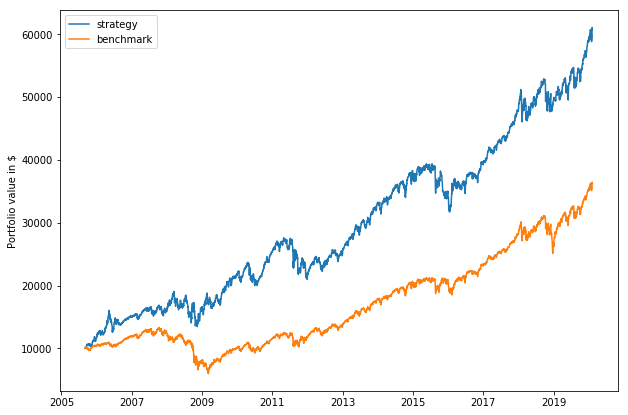

In [21]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades - this graph requires some interpretation.  The black up arrows represent a sell/buy pair.  Either SPY/GLD sell/buy or GLD/SPY sell/buy.  These will alternate.  If the market is starting to fall, SPY is traded out for GLD.  If the market is starting to rise, the GLD is traded out for SPY.

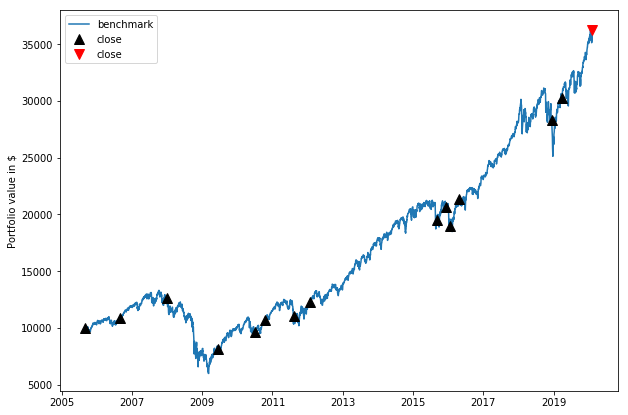

In [22]:

pf.plot_trades(dbal, benchmark=benchmark.dbal)

Strategy vs Benchmark

In [23]:
df = pf.summary5(stats, benchmark.stats)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$60,727.35","$36,265.21"
total_net_profit,"$50,727.35","$26,265.21"
gross_profit,"$56,780.83","$26,265.21"
gross_loss,"-$6,053.47",$0.00


,strategy,benchmark
annual_return_rate,13.31,9.34
max_closed_out_drawdown,-29.39,-54.96
drawdown_annualized_return,-2.21,-5.89
drawdown_recovery,-0.66,-1.42
best_month,22.99,23.40
worst_month,-19.65,-29.26
sharpe_ratio,0.81,0.58
sortino_ratio,1.02,0.70
monthly_std,4.49,4.25
trades_per_year,0.97,0.07


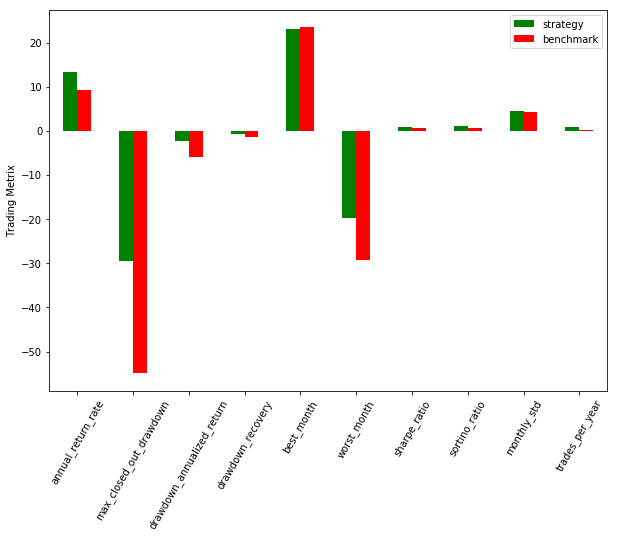

In [24]:
metrics = ('annual_return_rate',
           'max_closed_out_drawdown',
           'drawdown_annualized_return',
           'drawdown_recovery',
           'best_month',
           'worst_month',
           'sharpe_ratio',
           'sortino_ratio',
           'monthly_std',
           'trades_per_year')

df = pf.plot_bar_graph(stats, benchmark.stats, *metrics)
df